__Нейросетевая языковая модель на основе схемы Seq2Seq__

Евгений Борисов esborisov@sevsu.ru

https://drive.google.com/file/d/166Msc4oTDy2wFWd5_VnuZES3dduvpMD1/view?usp=share_link

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()
np.set_printoptions(precision=2)

# загружаем данные

In [2]:
# %%time 

# import zipfile
# import requests
# from io import StringIO,BytesIO

# file_id = '166Msc4oTDy2wFWd5_VnuZES3dduvpMD1'
# url = f'https://drive.google.com/uc?id={file_id}'

# with requests.get(url,stream=True) as r:
#     with zipfile.ZipFile(BytesIO(r.content)) as z:
#         with z.open('Rus-Eng-small.tsv') as f:
#             df = pd.read_csv( 
#                 StringIO( str(f.read(),encoding='utf-8' )[1:] ), 
#                 sep='\t',
#                 header=None,
#                 names=['N_Rus','Rus','N_Eng','Eng'] 
#             )


In [3]:
# !ls tmp/data

In [4]:
# df = pd.read_pickle('data/data.pkl.gz')
df = pd.read_pickle('tmp/data/rus-eng-small.pkl.gz')
display(len(df))
display(df.info())
display(df.sample(10))

200000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   N_Rus   200000 non-null  int64 
 1   Rus     200000 non-null  object
 2   N_Eng   200000 non-null  int64 
 3   Eng     200000 non-null  object
dtypes: int64(2), object(2)
memory usage: 6.1+ MB


None

,N_Rus,Rus,N_Eng,Eng
118720,3326921,Ты принял взятку или нет?,326581,Did you or did you not accept the bribe?
67149,2580252,Я повстречала Тома на вечеринке.,2387132,I met Tom at a party.
105014,3073036,Она не прочитала книгу.,311418,She did not read the book.
197061,4347525,Не забудь написать индекс.,4198352,Don't forget to write the zip code.
99567,3010668,Вы уезжаете этим летом?,60186,Are you going away this summer?
49579,2264189,Не ведите себя как ребёнок.,2264188,Don't act like a child.
106962,3096457,"Готов поспорить, что Вы отличный учитель.",2294112,I bet you're a great teacher.
148517,3707033,Том — ответственный за барбекю.,1690877,Tom is in charge of the barbecue.
151058,3757553,Ты должен был позволить мне тебе помочь.,3372948,You should've let me help you.
114017,3260866,Сын моей сестры - это наш племянник.,1744385,My sister's son is our nephew.


In [5]:
display( len(df) )
df = df.drop_duplicates('N_Rus').drop_duplicates('N_Eng').reset_index(drop=True)
display( len(df) )

200000

147087

# выбираем пары для обучения модели

## анализ словаря

In [6]:
# !pip install razdel

In [7]:
from razdel import tokenize
from nltk.tokenize import word_tokenize as nltk_tokenize_word

In [8]:
# CountVectorizer(
#     *, 
#     input='content', 
#     encoding='utf-8', 
#     decode_error='strict', 
#     strip_accents=None, 
#     lowercase=True, 
#     preprocessor=None, 
#     tokenizer=None, 
#     stop_words=None, 
#     token_pattern='(?u)\b\w\w+\b', 
#     ngram_range=(1, 1), 
#     analyzer='word', 
#     max_df=1.0, 
#     min_df=1, 
#     max_features=None, 
#     vocabulary=None, 
#     binary=False, 
#     dtype=<class 'numpy.int64'>
# )

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from razdel import tokenize

In [10]:
import re

df['Rus'] = df['Rus'].progress_apply(lambda s: re.sub(r'[«»]','"',s))

  0%|          | 0/147087 [00:00<?, ?it/s]

In [11]:
def tokenizer_ru(s): return [ t.text for t in tokenize(s) ] 

cv_ru = CountVectorizer(
        lowercase=False,
        token_pattern=None,
        tokenizer=tokenizer_ru, 
        min_df=2,
    ).fit(df['Rus'])

vocab_ru = cv_ru.vocabulary_
display( len(vocab_ru) )

vocab_ru_ = (
    pd.DataFrame(
        [ [v,k] for k,v in  vocab_ru.items() ],columns=['index','word']
    )
        .sort_values(by='index')
        .set_index('index')
    )
vocab_ru_['tf'] = cv_ru.transform(df['Rus']).sum(axis=0).T

display( vocab_ru_ )

# vocab_ru_.sort_values(by='tf').to_csv('tmp/vocab_ru.csv',index=False,sep='\t')

display( vocab_ru_[['tf']].describe([.01, .25, .75, .95, .99 ]).T )

29472

,word,tf
index,,
0,!,3818
1,!!!,5
2,!..,3
3,"""",4745
4,$,3
...,...,...
29467,“,9
29468,”,5
29469,„,4


,count,mean,std,min,1%,25%,50%,75%,95%,99%,max
tf,29472.0,34.5985,864.259552,2.0,2.0,2.0,4.0,9.0,61.0,324.58,126855.0


In [12]:
# vocab_ru_.query('tf<2').sort_values(by='tf')

In [13]:
# vocab_ru_.query('tf>188').sort_values(by='tf')

In [14]:
del vocab_ru_

---

In [15]:
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.tokenize import word_tokenize as nltk_tokenize_word

def tokenizer_en(s): return nltk_tokenize_word(s,language='english') 

cv_en = CountVectorizer(
        lowercase=False,
        token_pattern=None,
        tokenizer=tokenizer_en, 
        min_df=2,
    ).fit(df['Eng'])

vocab_en = cv_en.vocabulary_
display( len(vocab_en) )

vocab_en_ = (
    pd.DataFrame(
        [ [v,k] for k,v in  vocab_en.items() ],columns=['index','word']
    )
        .sort_values(by='index')
        .set_index('index')
    )

vocab_en_['tf'] = cv_en.transform(df['Eng']).sum(axis=0).T

display( vocab_en_ )

# vocab_en_.sort_values(by='tf').to_csv('tmp/vocab_en.csv',index=False,sep='\t')

display( vocab_en_[['tf']].describe([.01, .25, .75, .95, .99 ]).T )

13494

,word,tf
index,,
0,!,3397
1,$,37
2,%,56
3,&,3
4,',207
...,...,...
13489,—,45
13490,‘,23
13491,’,103


,count,mean,std,min,1%,25%,50%,75%,95%,99%,max
tf,13494.0,88.466726,1370.468131,2.0,2.0,3.0,5.0,17.0,168.0,1119.35,127460.0


In [16]:
del vocab_en_

## выделяем тестовый набор

In [17]:
# считаем количество слов
df['Rus_len_seq'] = df['Rus'].progress_apply(lambda s: len( tokenizer_ru(s) )  )
df['Eng_len_seq'] = df['Eng'].progress_apply(lambda s: len( tokenizer_en(s) ) )
display( df[['Rus_len_seq','Eng_len_seq']].describe().astype(int).T )

  0%|          | 0/147087 [00:00<?, ?it/s]

  0%|          | 0/147087 [00:00<?, ?it/s]

,count,mean,std,min,25%,50%,75%,max
Rus_len_seq,147087,7,4,2,5,6,8,173
Eng_len_seq,147087,8,4,2,6,7,9,232


In [18]:
l_min,l_max = 3,10

# выбираем последовательности приблизительно одинаковой длинны
df_train = df.query(f'({l_min}<Rus_len_seq<{l_max})&({l_min}<Eng_len_seq<{l_max})')
display( len(df_train) )
display( df_train.sample(7) )

103883

,N_Rus,Rus,N_Eng,Eng,Rus_len_seq,Eng_len_seq
13029,598355,В Киото много чего посмотреть.,19326,There are many sights to see in Kyoto.,6,9
64186,2763461,По какой дисциплине вы специализировались?,2763460,What was your major?,6,5
1164,394367,Не разговаривай за столом.,268753,Be quiet at the table.,5,6
16568,811588,Какая это буква?,519696,What is this letter?,4,5
87857,3281889,Ты попросту тратишь без дела своё время.,3281679,You're just wasting your time.,8,7
129886,4037258,Я им всё про тебя рассказал.,3905287,I've told them all about you.,7,8
79766,3060783,Этот магазин поставляет нам кофе.,3060782,That store supplies us with coffee.,6,7


In [19]:
df_test = df_train.sample( len(df_train)//10 )
df_train = df_train.drop(df_test.index)

df_val = df_train.sample( len(df_train)//10 )
df_train = df_train.drop(df_val.index)

display( len(df_train), len(df_val), len(df_test) )

84146

9349

10388

# собираем генератор датасета

In [20]:
# vocab_en

In [21]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [22]:
class TextPairDataset(Dataset):

    def __init__(self, df,vocab,cols={'Rus':'russian','Eng':'english'}):
        super().__init__()

        assert len(cols)==2
        assert len(df)>1
        self._lang = cols
        self._data = df[self._lang.keys()].reset_index(drop=True)
        # self._vocab = vocab if vocab
        #         else { k : self._make_vocab(df[k],language=self._lang[k]) for k in self._lang } 
        self._vocab = vocab 
        self._max_seq = { k : self._get_max_seq(df[k],language=self._lang[k]) for k in self._lang }
    
    @staticmethod
    def  _tokenize(s,language):
        return nltk_tokenize_word(s,language=language)

#     @classmethod
#     def _make_vocab(cls,d,language):
#         words = sorted(set.union(*[ set(  cls._tokenize(s,language) ) for s in tqdm(d) ]))
#         return { w:n+1 for n,w in enumerate(words) } | { '<PAD>':0, '<EOS>':len(words)+2, '<UNK>':len(words)+3 }
    
    @classmethod
    def _get_max_seq(cls,d,language):
        return max([ len(cls._tokenize(s,language)) for s in tqdm(d) ])
    
    @property
    def vocab(self):
        return self._vocab

    @vocab.setter
    def vocab(self,vocab):
        self._vocab = vocab

    @property
    def data(self):
        return self._data
        
    def __len__(self):
        return len(self._data)
    
    @property
    def max_seq(self):
        return self._max_seq
    
    def _encode(self,s,language,vocab):
        return [ vocab['<UNK>'] if not(w in vocab) else vocab[w] for w in self._tokenize(s,language) ] 
        
    def _pad_seq(self,s,max_seq,eos_code):
        return [0]*(max_seq-len(s)) + s + [eos_code]
    
    def __getitem__(self, idx):
        return  [
            torch.LongTensor(
                    np.array(
                        self._pad_seq(
                            self._encode( self._data[c][idx], language=self._lang[c] , vocab=self._vocab[c] ) 
                            ,max_seq=self._max_seq[c]
                            ,eos_code=self._vocab[c]['<EOS>']
                        ) 
                        ,dtype=int
                    )
            )
            for c in self._lang 
        ]

----

In [23]:
vocab_ru = { w:n+1 for n,w in enumerate(sorted(vocab_ru.keys())) }
ru_max_idx = max(vocab_ru.values())
vocab_ru =  vocab_ru | { '<PAD>':0, '<EOS>':ru_max_idx+1, '<UNK>':ru_max_idx+2, }
display( len(vocab_ru) )

del ru_max_idx

29475

In [24]:
vocab_en = { w:n+1 for n,w in enumerate(sorted(vocab_en.keys())) }
en_max_idx = max(vocab_en.values())
vocab_en =  vocab_en | { '<PAD>':0, '<EOS>':en_max_idx+1, '<UNK>':en_max_idx+2, }
display( len(vocab_en) )
del en_max_idx

13497

In [25]:
vocab = { 'Rus': vocab_ru, 'Eng': vocab_en, }

In [26]:
del vocab_ru
del vocab_en

---

In [27]:
ds_train = TextPairDataset( df_train, vocab=vocab )

  0%|          | 0/84146 [00:00<?, ?it/s]

  0%|          | 0/84146 [00:00<?, ?it/s]

In [28]:
ds_val = TextPairDataset(df_val, vocab=ds_train.vocab)

  0%|          | 0/9349 [00:00<?, ?it/s]

  0%|          | 0/9349 [00:00<?, ?it/s]

In [29]:
display( ds_train.max_seq, ds_val.max_seq )

{'Rus': 9, 'Eng': 9}

{'Rus': 9, 'Eng': 9}

In [30]:
# for input_tensor, target_tensor in DataLoader( ds_train, batch_size=3, shuffle=True): 
#     break

# display( input_tensor, target_tensor )

In [31]:
# with torch.set_grad_enabled(False):
#     o,h = model_encoder(t0)
#     r  = model_decoder(encoder_outputs=o,encoder_hidden=h)

# строим модель

In [32]:
import torch.nn as nn
import torch.nn.functional as F

In [33]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, embedding_dim, encoder_hidden_dim,): 
        super(Encoder, self).__init__()
        self._emb = nn.Embedding(vocab_len, embedding_dim)
        self._rnn = nn.GRU(
                input_size=embedding_dim, 
                hidden_size=encoder_hidden_dim, 
                num_layers=2, 
                batch_first=True,
                dropout=0.4,
            )

    def forward(self, x):
        o = self._emb(x)
        o, h = self._rnn(o)
        return o,h

In [34]:
# vocab_len = len(ds.vocab['Rus'])
# embedding_dim = 256
# encoder_hidden_dim = 128

# model_encoder = Encoder(
#         vocab_len=vocab_len+1,
#         embedding_dim=embedding_dim,
#         encoder_hidden_dim=encoder_hidden_dim,
#     )

# with torch.set_grad_enabled(False):
#     o,h = model_encoder(t0)
    
# display( o.shape, h.shape )

In [35]:
# torch.empty(3, 1, dtype=torch.long).fill_(0)

In [36]:
class Decoder(nn.Module):
    
    def __init__(self, hidden_size, output_size, max_seq_len, device='cpu'):
        super(Decoder, self).__init__()
        self._emb = nn.Embedding(num_embeddings=output_size, embedding_dim=hidden_size)
        self._rnn = nn.GRU( 
                input_size=hidden_size, 
                hidden_size=hidden_size, 
                num_layers=2, 
                batch_first=True,
                dropout=0.4,
            )
        self._lin = nn.Linear(in_features=hidden_size, out_features=output_size, bias=True,)
        #self._dp = nn.Dropout(0.1)
        self._device = device
        self._max_seq_len = max_seq_len

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=self._device).fill_(0)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(self._max_seq_len):
            decoder_output, decoder_hidden  = self._forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def _forward_step(self,x,hidden):
        o = F.relu( self._emb(x) )
        o,h = self._rnn(o, hidden)
        # o = self._dp( self._lin(o) )
        o = self._lin(o)
        return o,h

----

In [37]:
# # проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device='cpu'
display( device )

device(type='cuda', index=0)

In [38]:
vocab_input_len  = len(ds_train.vocab['Rus'])
vocab_output_len = len(ds_train.vocab['Eng'])
max_output_seq_len = ds_train.max_seq['Eng']+1

In [72]:
# del model_encoder
# del model_decoder
# del input_tensor
# del target_tensor
# del encoder_outputs
# del encoder_hidden
# del decoder_outputs

In [73]:
embedding_dim = 1024
encoder_hidden_dim = 256

model_encoder = Encoder(
        vocab_len=vocab_input_len+1,
        embedding_dim=embedding_dim,
        encoder_hidden_dim=encoder_hidden_dim,
    ).to(device)

model_decoder = Decoder( 
        hidden_size=encoder_hidden_dim, 
        output_size=vocab_output_len+1, 
        max_seq_len=max_output_seq_len,
        device=device,
    ).to(device)

In [74]:
display( vocab_input_len, vocab_output_len )

29475

13497

In [75]:
display( max(ds_train.vocab['Rus'].values()),  max(ds_train.vocab['Eng'].values()) )

29474

13496

In [76]:
# x,y = ds_train[:2]
# with torch.set_grad_enabled(False):
#     o,h = model_encoder(x.to(device))
#     r  = model_decoder(encoder_outputs=o,encoder_hidden=h)

# r[0].shape, r[1].shape, # r[3].shape

In [77]:
# r[0].view(-1, r[0].size(-1)).shape
# r[0].shape ,  t1.shape

In [78]:
# display( r[0].view(-1, r[0].size(-1)).shape )
# display( t1.view(-1).shape )

In [79]:
# criterion = nn.NLLLoss()
# with torch.set_grad_enabled(False):    
#     loss = criterion(
#             r[0].view(-1, r[0].size(-1)),
#             t1.view(-1)
#         )
# loss.item()

# обучаем 

In [80]:
from torch import optim

learning_rate = 1e-3
encoder_optimizer = optim.Adam( model_encoder.parameters(), lr=learning_rate )
decoder_optimizer = optim.Adam( model_decoder.parameters(), lr=learning_rate )
criterion = nn.NLLLoss()

In [81]:
display( len(ds_train) )

84146

In [82]:
# with torch.set_grad_enabled(False):
#     for input_tensor, target_tensor in DataLoader( ds, batch_size=3, shuffle=True): 
#         encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
#         decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
#         break

# decoder_outputs

In [83]:
# encoder_outputs
# encoder_hidden

In [84]:
# история значений ф-ции потери
loss_history_train = [] 
loss_history_val = []

In [87]:
%%time

# n_epoch = 64 # количество эпох обучения
# batch_size = 512*3
# lag_val_check = 4
# n_iter_no_check = n_epoch*0.33

n_epoch = 8 # количество эпох обучения
batch_size = 1024*4

lag_val_check = 2
n_iter_no_check = 4

assert n_iter_no_check>lag_val_check

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    
    # получаем батч учебных примеров
    for input_tensor, target_tensor in DataLoader( ds_train, batch_size=batch_size, shuffle=True): 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
        decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.to(device).view(-1)
        )
        loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче
        
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
   
    loss_history_train.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
    
    
    loss_batch = []
    with torch.set_grad_enabled(False):   
        # получаем батч проверочных примеров
        for input_tensor, target_tensor in DataLoader( ds_val, batch_size=batch_size, shuffle=False): 
            encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
            decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.to(device).view(-1)
            )
            loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче

    loss_history_val.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери

    if i>n_iter_no_check:
        if ( loss_history_val[-lag_val_check]<loss_history_val[-1] ):
            print( 'validation loss value up, stoped\n' )
            break

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 2min 30s, sys: 849 ms, total: 2min 30s
Wall time: 2min 30s


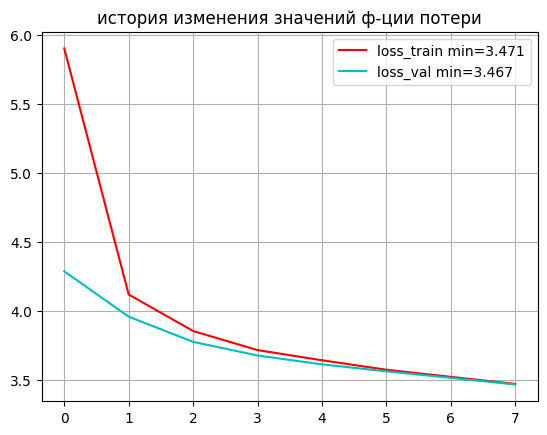

In [88]:
# история изменения значений ф-ции потери
plt.plot(loss_history_train,label='loss_train min=%.3f'%(min(loss_history_train)),c='r')
plt.plot(loss_history_val,label='loss_val min=%.3f'%(min(loss_history_val)),c='c')
plt.grid()
plt.title('история изменения значений ф-ции потери')
plt.legend()

# Тестируем

In [91]:
# !pip install torchtext

In [92]:
# from nltk.translate.bleu_score import sentence_bleu
from torchtext.data.metrics import bleu_score

In [93]:
def decode(code,voc): return ' '.join([ voc[c] for c in code if c!=0 ])

In [94]:
voc_ru = { v:k for k,v in ds_train.vocab['Rus'].items() }
voc_en = { v:k for k,v in ds_train.vocab['Eng'].items() }

### на учебном наборе

In [95]:
%%time 

init_seq = []
hypothesis = []
reference = []

with torch.set_grad_enabled(False):
    for input_tensor, target_tensor in DataLoader( ds_train, batch_size=batch_size, shuffle=False): 
        encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
        decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
        
        init_seq.append( input_tensor.cpu().numpy() )
        
        reference.append( target_tensor.cpu().numpy() )
        
        hypothesis.append( 
            np.swapaxes(np.argmax(
                decoder_outputs.cpu().numpy()
                ,axis=-1,keepdims=True),2,1)
        )

init_seq = np.vstack( init_seq )        
reference = np.vstack( reference )
hypothesis = np.vstack( hypothesis )

display( init_seq.shape, reference.shape, hypothesis.shape, )

(84146, 10)

(84146, 10)

(84146, 1, 10)

CPU times: user 24.3 s, sys: 3.21 s, total: 27.5 s
Wall time: 27.3 s


In [96]:
%%time 

display( bleu_score( reference.astype(str) , hypothesis.astype(str) ) )

0.14059098064899445

CPU times: user 14.8 s, sys: 11.9 ms, total: 14.9 s
Wall time: 15 s


In [97]:
df_train_  = pd.DataFrame({
        'Rus': [ decode( v , voc_ru ) for v in tqdm( init_seq) ],
        'Eng_target': [ decode( v , voc_en ) for v in tqdm(reference) ],
        'Eng_predicted': [ decode( v , voc_en ) for v in tqdm( np.squeeze(hypothesis)) ],
    })

display( df_train_.sample(17) )

  0%|          | 0/84146 [00:00<?, ?it/s]

  0%|          | 0/84146 [00:00<?, ?it/s]

  0%|          | 0/84146 [00:00<?, ?it/s]

,Rus,Eng_target,Eng_predicted
56004,Ты выглядишь очень хорошо . <EOS>,You look very nice . <EOS>,is to . . <EOS>
56535,Мы собираемся покрасить стену . <EOS>,We 're going to paint the wall . <EOS>,is to the to the . . <EOS>
61591,Они не говорят нам правду . <EOS>,They are not telling us the truth . <EOS>,is n't to to to . . <EOS>
32677,Флаг <UNK> на ветру . <EOS>,The flag <UNK> in the breeze . <EOS>,is n't to the . . <EOS>
42493,"Как ты думаешь , что это значит ? <EOS>",What do you think it means ? <EOS>,is n't n't n't to . <EOS>
68772,Том мне как отец . <EOS>,Tom is like a father to me . <EOS>,is to the the the the . <EOS>
43667,Почему ты ушёл ? <EOS>,Why did you leave ? <EOS>,is n't you . <EOS>
44478,"Том старше , чем выглядит . <EOS>",Tom is older than he looks . <EOS>,is to to the you . <EOS>
16210,"Я могу бегать быстрее , чем Кен . <EOS>",I can run faster than Ken . <EOS>,I 'm n't to to me . <EOS>
12059,"Я посетил деревню , в которой он родился . <EOS>",I visited the village where he was born . <EOS>,'m to to to to the me . <EOS>


In [98]:
del init_seq
del hypothesis
del reference

### на тестовом наборе

In [99]:
ds_test = TextPairDataset(df_test, vocab=ds_train.vocab)

  0%|          | 0/10388 [00:00<?, ?it/s]

  0%|          | 0/10388 [00:00<?, ?it/s]

In [100]:
%%time 

init_seq = []
hypothesis = []
reference = []

with torch.set_grad_enabled(False):
    for input_tensor, target_tensor in DataLoader( ds_test, batch_size=batch_size, shuffle=False): 
        encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
        decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
        
        init_seq.append( input_tensor.cpu().numpy() )
        
        reference.append( target_tensor.cpu().numpy() )
        
        hypothesis.append( 
            np.swapaxes(np.argmax(
                decoder_outputs.cpu().numpy()
                ,axis=-1,keepdims=True),2,1)
        )

init_seq = np.vstack( init_seq )        
reference = np.vstack( reference )
hypothesis = np.vstack( hypothesis )

display( init_seq.shape, reference.shape, hypothesis.shape, )

(10388, 10)

(10388, 10)

(10388, 1, 10)

CPU times: user 3.14 s, sys: 387 ms, total: 3.53 s
Wall time: 3.52 s


In [101]:
%%time 

display( bleu_score( reference.astype(str) , hypothesis.astype(str) ) )

0.14123807847499847

CPU times: user 1.89 s, sys: 50 µs, total: 1.89 s
Wall time: 1.9 s


In [102]:
df_test_  = pd.DataFrame({
        'Rus': [ decode( v , voc_ru ) for v in tqdm( init_seq) ],
        'Eng_target': [ decode( v , voc_en ) for v in tqdm(reference) ],
        'Eng_predicted': [ decode( v , voc_en ) for v in tqdm( np.squeeze(hypothesis)) ],
    })

display( df_test_.sample(17) )

  0%|          | 0/10388 [00:00<?, ?it/s]

  0%|          | 0/10388 [00:00<?, ?it/s]

  0%|          | 0/10388 [00:00<?, ?it/s]

,Rus,Eng_target,Eng_predicted
1318,Он воспользовался этой возможностью . <EOS>,He took advantage of the opportunity . <EOS>,is to the the . . <EOS>
5382,Это старая книга . <EOS>,This is an old book . <EOS>,is to the . . <EOS>
10051,Он взглянул на часы . <EOS>,He glanced at his watch . <EOS>,is the the . . <EOS>
10228,Том рассказал Мэри всё о своём детстве . <EOS>,Tom told Mary all about his childhood . <EOS>,is to to to the . . <EOS>
668,Том загадал желание . <EOS>,Tom made a wish . <EOS>,is to . . <EOS>
752,Я вешу пятьдесят восемь килограмм . <EOS>,I weigh 58 kilograms . <EOS>,I I you to . . <EOS>
10300,Я не хочу готовить еду . <EOS>,I do n't want to cook . <EOS>,I do n't n't to you . <EOS>
4679,Я видел тебя с ним в парке . <EOS>,I saw you in the park with him . <EOS>,'m to n't to the to . . <EOS>
9793,Ты скоро привыкнешь к шуму . <EOS>,You 'll soon get used to the noise . <EOS>,is to to the the the . . <EOS>
5345,Мы встретились лишь сегодня вечером . <EOS>,We just met tonight . <EOS>,I I is to . . <EOS>


In [103]:
del init_seq
del hypothesis
del reference

---

In [ ]:
# from torchtext.data.metrics import bleu_score

# candidate_corpus = [
#     ['My', 'full', 'pytorch', 'test'], 
#     ['Another', 'Sentence']
# ]

# references_corpus = [
#     [
#         ['My', 'full', 'pytorch', 'test'], 
#         ['Completely', 'Different']
#     ], [
#         ['No', 'Match']
#     ]
# ]

# bleu_score(candidate_corpus, references_corpus)

In [ ]:
# from nltk.translate.bleu_score import sentence_bleu

# hypothesis = ['It', 'is', 'a', 'cat', 'at', 'room']
# reference = ['It', 'is', 'a', 'cat', 'inside', 'the', 'room']

# # hypothesis = [ '0', '1', '2', '3', '4', '6']
# # reference = [ '0', '1', '2', '3',  '5', '7', '6' ]

# bleu_score([hypothesis], [[reference,]])